I:\Anaconda\envs\tf\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
7/7 [==============================] - 8s 715ms/step - loss: 0.8070 - accuracy: 0.5147 - val_loss: 0.6152 - val_accuracy: 0.7833
Epoch 2/20
7/7 [==============================] - 4s 559ms/step - loss: 0.7350 - accuracy: 0.5637 - val_loss: 0.5231 - val_accuracy: 0.8500
Epoch 3/20
7/7 [==============================] - 4s 577ms/step - loss: 0.5954 - accuracy: 0.6961 - val_loss: 0.4493 - val_accuracy: 0.9333
Epoch 4/20
7/7 [==============================] - 4s 555ms/step - loss: 0.5019 - accuracy: 0.7990 - val_loss: 0.3942 - val_accuracy: 0.9167
Epoch 5/20
7/7 [==============================] - 4s 562ms/step - loss: 0.4673 - accuracy: 0.8284 - val_loss: 0.3525 - val_accuracy: 0.9333
Epoch 6/20
7/7 [==============================] - 4s 555ms/step - loss: 0.4315 - accuracy: 0.8578 - val_loss: 0.3243 - val_accuracy: 0.9333
Epoch 7/20
7/7 [==============================] - 4s 599ms/step - loss: 0.3389 - accuracy: 0.9020 - val_loss: 0.3004 - val_accuracy: 0.9333
Epoch 8/20
7/7 [====

I:\Anaconda\envs\tf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


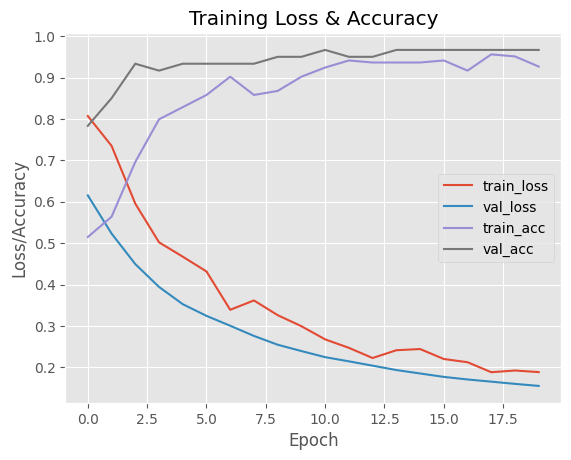

In [4]:
#neccesary library import
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

#initializing learning rate, number of epochs and batch size
Learn_rate = 1e-4
Epoch      = 20
Batch_size = 32

#dataset path
Directory = 'J:/11th Semester/CVPR/FINAL/Mask_Detection/Data'
Categories = ["with_mask", "without_mask"]

data   = []
labels = []

for category in Categories:
  path = os.path.join(Directory, category)
  for img in os.listdir(path):
    img_path = os.path.join(path, img)
    image = load_img(img_path, target_size=(224,224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(category)

#converting aplhabetical values of labels into number values
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

#converting data and labels into numpy array
data = np.array(data, dtype="float32")
labels = np.array(labels)

#spliting train data and test data
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=16)
#trainX = train image, trainY = train image labels; testX = test image, testY = test image label
#test_size = 0.20; 20% images set for testing

#data augmentation generating multiple variations of each image wih following properties
aug = ImageDataGenerator(
    rotation_range      = 20,
    zoom_range          = 0.15,
    width_shift_range   = 0.2,
    height_shift_range  = 0.2,
    shear_range         = 0.15,           #the angle of tilt
    horizontal_flip     = True,
    fill_mode           = "nearest"       #replaces empty areas with nearest pixel values
    )

#loading MobileNetV2 network
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#previously trained imagenet is used on weight; initital fully connected layer is left off; shape of the image is defined (224 × 224 ×3)

#constructing head of the model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name = "flatten")(headModel)
headModel = Dense(128, activation = "relu")(headModel)        #dense layer with 128 neurons; relu for non-linear use case
headModel = Dropout(0.5)(headModel)                           #Just to avoid any overfitting
headModel = Dense(2, activation = "softmax")(headModel)       #output has 2 layers; dealing with binary classifications and so used softmax

#calling the model function that accepts two parameters
#Head of the model is placed on top of base model
model = Model(inputs = baseModel.input, outputs = headModel)

#freezing all of the layers of base model so they are not going to be updated during first training process
for layer in baseModel.layers:
  layer.trainable = False

#compiling the model
opt = tf.keras.optimizers.Adam(lr = Learn_rate, decay = Learn_rate/Epoch)
model.compile(loss = "binary_crossentropy", optimizer=opt, metrics=["accuracy"])

#training the head of the network
H = model.fit(
    aug.flow(trainX, trainY, batch_size = Batch_size),
    steps_per_epoch = len(trainX) // Batch_size,
    validation_data = (testX, testY),
    validation_steps = len(testX) // Batch_size,
    epochs = Epoch
)

#making predictions on the testing set
predict_m = model.predict(testX, batch_size = Batch_size)

#finding the index of the label with corresponding largest predicted probability
predict_m = np.argmax(predict_m, axis = 1)

#formatting the classification report
print(classification_report(testY.argmax(axis = 1), predict_m, target_names = lb.classes_))

#saving the model
model.save('J:/11th Semester/CVPR/FINAL/Mask_Detection/SavedFiles/model.hdf5')

#plotting training loss and accuracy
N = Epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label = "val_acc")
plt.title("Training Loss & Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc = "center right")

#saving the graph as .PNG
plt.savefig('J:/11th Semester/CVPR/FINAL/Mask_Detection/SavedFiles/graph.png')